In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [4]:
train.head(50)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
43360,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,NaN,True,VWC,K,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,7,27,NaN,True
7263,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175.0,True,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,3,23,3.0,False
2486,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300.0,True,VWC,NaN,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,False,False,False,False,False,2011,3,7,1.0,False
313,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,NaN,True,NaN,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,False,False,True,True,True,2011,7,31,NaN,True
52726,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,NaN,True,VWC,Zeje,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,3,10,NaN,True
8558,0.0,Dwe/norad,1295.0,DWE,31.214583,-8.431428,Kwa Feston Mambosasa,0,Lake Tanganyika,Kisumba Kati,Rukwa,15,2,Sumbawanga Rural,Kasanga,200.0,True,VWC,Kisumba water supply,True,1986.0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,8,7,25.0,False
2559,20000.0,Oxfam,1515.0,DWE,36.696700,-3.337926,Oroirwa,0,Pangani,Oroirwa,Arusha,2,2,Arusha Rural,Oltroto,150.0,True,VWC,Nabaiye pipe line,True,1995.0,gravity,gravity,gravity,vwc,user-group,pay monthly,soft,good,insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe,functional,False,False,False,False,False,2013,9,3,18.0,False
54735,0.0,Water,NaN,DWE,36.292724,-5.177333,Zahanati,0,Internal,Polisi,Dodoma,1,1,Kondoa,Mrijo,NaN,True,VWC,Mrij,False,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,4,17,NaN,True
25763,0.0,Danida,NaN,DANIDA,32.877248,-8.925921,Mwambasi,0,Lake Rukwa,Bagamoyo,Mbeya,12,6,Mbozi,Halungu,NaN,False,VWC,NaN,False,NaN,swn 80,swn 80,handpump,vwc,user-group,never pay,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional,False,False,True,True,True,2011,8,3,NaN,True
44540,0.0,Tancan,NaN,TANCAN,33.014412,-3.115869,Mwanzuki,0,Lake Victoria,Mwanzuki,Mwanza,19,7,Missungwi,Shilalo,NaN,True,VWC,NaN,True,NaN,submersible,submersible,submersible,vwc,user-group,pay monthly,soft,good,enough,machine dbh,borehole,groundwater,other,other,non functional,False,False,True,True,True,2011,8,3,NaN,True


In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()



In [6]:
cardinality

funder                        1716
installer                     1929
wpt_name                     30661
basin                            9
subvillage                   17231
region                          21
lga                            124
ward                          2082
public_meeting                   2
scheme_management               12
scheme_name                   2563
permit                           2
extraction_type                 18
extraction_type_group           13
extraction_type_class            7
management                      12
management_group                 5
payment                          7
water_quality                    8
quality_group                    6
quantity                         5
source                          10
source_type                      7
source_class                     3
waterpoint_type                  7
waterpoint_type_group            6
longitude_MISSING                2
latitude_MISSING                 2
construction_year_MI

In [0]:
# categorical_features.append('ward')

In [0]:
# categorical_features.append('funder')

In [0]:
categorical_features.append('installer')

In [0]:
# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [14]:
# TODO
%%time

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8105218855218855
CPU times: user 15.7 s, sys: 251 ms, total: 15.9 s
Wall time: 8.69 s


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get encoded values
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)
print ('Print X_train shape after encoding', encoded.shape)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

Print X_train shape after encoding (47520, 39)


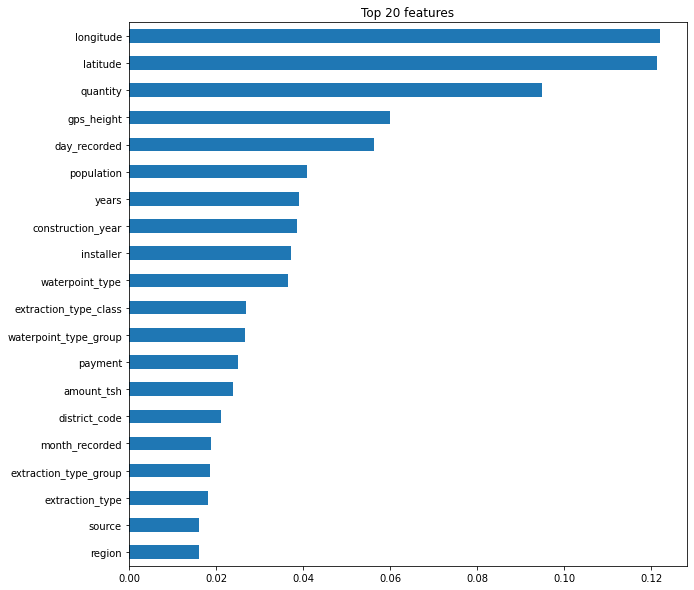

In [18]:
# Plot the top 20 features
n = 20
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [0]:
y_pred = pipeline.predict(X_test)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('kyle_tyler_last.csv', index=False)

In [0]:
from google.colab import files
files.download('kyle_tyler_last.csv')